<a href="https://colab.research.google.com/github/FedorTaggenbrock/data_intensive_systems/blob/main/notebooks/main_tests_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Handle importing/installing, both local and on Colab**

In [1]:
import sys
global ON_COLAB
ON_COLAB = 'google.colab' in sys.modules
if ON_COLAB:
    # Do stuff that only needs to happen on colab
    !pip install pyspark  # noqa
    !pip install ijson
    pass
else:
    # Do stuff that only needs to happen on local computer
    pass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=51ae348483ed0f0acff63301adee438abeefc40a9cc6012e46a4ab93bbf32ccd
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 5.0 MB/s eta 0:00:00


Rerun the code cell below to use the latest version of the python files!

In [10]:
import importlib

def import_modules():
    if ON_COLAB:
        print("Running in Colab: importing from GitHub.")
        # Clone the repository
        !git clone https://github.com/FedorTaggenbrock/data_intensive_systems.git

        # Change the current working directory to the cloned repository directory
        %cd /content/data_intensive_systems

        # Pull the latest changes from the repository
        !git pull origin main

        # Change back to the original working directory
        %cd /content

        # Add the path of the modules to sys.path
        sys.path.insert(0, "/content/data_intensive_systems/src")
    else:
        print("Running locally, importing from local.")
        # Append parent folder to path
        sys.path.append('../src')

    # Import and reload modules iteratively
    module_names = ['clustering',
                    'data_visualization',
                    'distance_functions',
                    'evaluate_clustering',
                    'generate_data',
                    'main_tests',
                    'plot_clustering',
                    # 'non_spark_function_debugger',
                    'parse_data',
                    # 'parse_data_2',
                    # 'parse_data_3',
                    'abe_tests',
                    ]
    for module_name in module_names:
        print(module_name)

        module = importlib.import_module(module_name)
        importlib.reload(module)
        globals()[module_name] = module

import_modules()


Running in Colab: importing from GitHub.
fatal: destination path 'data_intensive_systems' already exists and is not an empty directory.
/content/data_intensive_systems
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), 355 bytes | 355.00 KiB/s, done.
From https://github.com/FedorTaggenbrock/data_intensive_systems
 * branch            main       -> FETCH_HEAD
   299c3bf..aa3edea  main       -> origin/main
Updating 299c3bf..aa3edea
Fast-forward
 src/clustering.py | 4 ++--
 1 file changed, 2 insertions(+), 2 deletions(-)
/content
clustering
data_visualization
distance_functions
evaluate_clustering
generate_data
main_tests
plot_clustering
parse_data
abe_tests


In [ ]:
main_tests.run_all_tests()

Loading data


FileNotFoundError: ignored

-------

In [ ]:
abe_tests.__run_all_tests()

In [28]:
# General modules
import numpy as np
import scipy.spatial.distance
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import pickle
import sys
import os

# Spark etc
from pyspark import RDD
from pyspark.sql import SparkSession

# Typing
from typing import Any, Callable, Union


from pyspark.sql import SparkSession
import pandas as pd

# Own stuff

# from data_visualization import plot_routes, convert_pd_df_to_one_row
from plot_clustering import plot_metrics, plot_confusion_matrix
from clustering import run_clustering, run_final_clustering, route_distance
from parse_data import get_nested_data, get_vector_dataframe, get_data
from evaluate_clustering import evaluate_clustering, get_best_setting

def save_results_test(results, clustering_settings):
    os.makedirs('data/serialized_results_for_debugging/', exist_ok=True)
    # Make the name of the file
    algo = clustering_settings['clustering_algorithm']
    kvals = '[' + '-'.join( [str(kval) for kval in clustering_settings['k_values']] ) + ']'
    iters = clustering_settings['max_iterations']
    name = f"algo={algo}_kvalues={kvals}_maxiter={iters}"

    with open('data/serialized_results_for_debugging/results__{}__.pkl'.format(name), 'wb') as f:
        pickle.dump(results, f)

def load_results(path=r'data\serialized_results_for_debugging\results__algo=kmodes_kvalues=[3]_max_iter=4.pkl'):
    with open(path, 'rb') as f:
        return pickle.load(f)

clustering_settings = {
        'clustering_algorithm': 'kmeans',
        'k_values': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
        'distance_function': route_distance,
        'max_iterations': 4,
        'debug_flag': False,
    }

spark = None
spark = SparkSession.builder.appName("Clustering").getOrCreate()


print("Loading data")

_ON_COLAB = 'google.colab' in sys.modules
if clustering_settings['debug_flag']: print('On colab: ', _ON_COLAB)
general_data_path = r'\data\data_12_06\1000_0.25_actual_routes.json'
general_perfect_centroids_path = r'\data\data_12_06\10_standard_route.json'
try:
    if _ON_COLAB:
        data_path = '/content/data_intensive_systems' + general_data_path.replace("\\", "/")
        perfect_centroid_path = '/content/data_intensive_systems/data/data_12_06/10_standard_route.json'
    else:
        data_path = os.getcwd() + general_data_path
        perfect_centroid_path = os.getcwd() + general_perfect_centroids_path
except Exception as e:
    print('Data path was not found.\n\n', e)
    data_path = None
    perfect_centroid_path = None

# Load datafile
if clustering_settings['clustering_algorithm'] == 'kmodes':
    data = get_nested_data(spark, data_path, clustering_settings)
    perfect_centroids = get_nested_data(spark, perfect_centroid_path, clustering_settings)
elif clustering_settings['clustering_algorithm'] == 'kmeans':
    data, indices2from_to_prods = get_vector_dataframe(spark, data_path, clustering_settings["debug_flag"])
    perfect_centroids = get_vector_dataframe(spark, perfect_centroid_path, clustering_settings["debug_flag"])
else:
    data = None
    perfect_centroids = None

# Run the clustering algorithm
print("Running run_clustering().")
results_and_metrics = run_clustering(
    data=data,
    clustering_settings=clustering_settings
)

# Save the results (optional, Abe)
save_results_test(results_and_metrics, clustering_settings)

# Evaluate the clustering
results = results_and_metrics[0]
metrics = results_and_metrics[1]

if not metrics: # if kmodes, then metrics not yet calculated
    print("Start evaluating clusters")
    metrics = evaluate_clustering(
        data=data,
        clustering_result=results_and_metrics,
        clustering_settings=clustering_settings
    )



Loading data
Running run_clustering().
Performing clustering with k=4
Performing clustering with k=5
Performing clustering with k=6
Performing clustering with k=7
Performing clustering with k=8
Performing clustering with k=9
Performing clustering with k=10
Performing clustering with k=11
Performing clustering with k=12
Performing clustering with k=13



Best settings are given by: 
 {'k': 7}


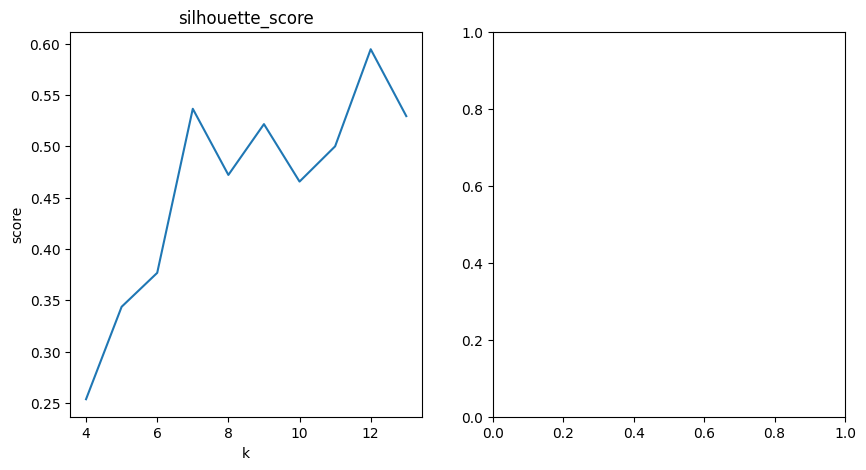

In [29]:
best_settings = get_best_setting(metrics)
print("\nBest settings are given by: \n", best_settings)

# Generate plots
metric_plot = plot_metrics(metrics, clustering_settings)
metric_plot.show()

In [30]:
# Get final results
clustered_data, predicted_centroids, metric = run_final_clustering(
    data=data,
    clustering_settings=clustering_settings,
    best_setting=best_settings,
)

Running final clustering with k=7


In [80]:
import seaborn as sns
from pyspark.sql.functions import col, count
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import linear_sum_assignment

def get_confusion_matrix(clustered_df):
    # Generate a table which has the standard routes as rows and the cluster centres as columns. It shows for each found cluster center,
    #  which route it belongs to; this is because the datapoints in each cluster are grouped per standard-route-id.
    grouped_df = clustered_df.withColumn("sr\predicted_clusters", col("id-sr").substr(-1, 1)) \
    .groupBy("sr\\predicted_clusters") \
    .pivot("prediction") \
    .agg(count("*").alias("count"))

    return grouped_df


def plot_confusion_matrix(clustered_df):
    """
    Plots the confusion matrix.

    Args:
        grouped_df: A DataFrame containing the confusion matrix data.

    Returns:
        A matplotlib figure representing the confusion matrix.
    """

    # The id-number of the found cluster centers does not necessarily match the id-number of the standard routes.
    # Therefore, we need to map the found cluster center id's to the standard route id's, by seeing which cluster center
    # it corresponds with best. This is done by taking the max index (in terms of the row) for each column.
    # This is the standard route id that corresponds with the cluster center. However, a problem is there can be more or fewer cluster centers
    # than standard routes. Therefore, we need to check if there are duplicates in the resulting list of max-indices. The highest of the two, should be assigned
    # to that cluster center. The other one should be assigned to the next-best cluster-center, but only if it is a better match than the current one. Then, the current one
    # needs to be checked, and so on. Since there may be more centers than routes, it is okay that some get an id higher than the number of routes.

    debug1=True

    # Get the data from the dataframe into pandas format
    grouped_df = get_confusion_matrix(clustered_df)
    grouped_df_pd = grouped_df.toPandas()
    grouped_df_pd = grouped_df_pd.set_index('sr\\predicted_clusters').fillna(0)

    # Sort DataFrame by index of standard routes
    grouped_df_pd = grouped_df_pd.sort_index()

    # 1. Get max indices
    max_indices = grouped_df_pd.idxmax()

    if debug1: print(grouped_df_pd, '\n')
    if debug1: print('max_indices:',max_indices)

    # 2. Handle duplicate max indices

    # Normalize the data to reflect the "strength" of the association between the clusters and the routes
    grouped_df_pd_normalized = grouped_df_pd.divide(grouped_df_pd.sum(axis=0), axis=1)

    # 2. Handle duplicate max indices
    max_values = grouped_df_pd_normalized.max()
    assigned_clusters = []
    unassigned_routes = []

    for idx, val in max_indices.duplicated(keep=False).items():
        if val:
            duplicates = max_indices[max_indices == max_indices[idx]]
            for dup in duplicates.index:
                # 3. Reassign to next best
                if max_values[dup] < max_values[idx] or idx in assigned_clusters:
                    new_assignment = grouped_df_pd_normalized[dup].nlargest(2).index[1]
                    if new_assignment in assigned_clusters:
                        unassigned_routes.append(idx)
                    else:
                        max_indices[dup] = new_assignment
                        assigned_clusters.append(new_assignment)
                else:
                    assigned_clusters.append(idx)


    # 4. Handling more cluster centers than routes
    max_indices_list = max_indices.tolist()

    if debug1: print('max_indices_list',max_indices_list)

    if len(max_indices_list) > len(set(max_indices_list)):
        unique_vals = list(set(max_indices_list))
        duplicates = list(set([x for x in max_indices_list if max_indices_list.count(x) > 1]))
        for dup in duplicates:
            indices = [i for i, x in enumerate(max_indices_list) if x == dup]
            for ind in indices[1:]:
                max_indices_list[ind] = max(unique_vals) + 1
                unique_vals.append(max_indices_list[ind])

        if debug1: print('unique_vals', unique_vals)
        if debug1: print('duplicates', duplicates)
    else:
        if debug1: print('not len(max_indices_list) > len(set(max_indices_list))')

    # 5. Handling fewer cluster centers than routes

    if debug1: print(f"unassigned routes: {unassigned_routes}")

    for unassigned in unassigned_routes:
        max_indices_list[unassigned] = max(unique_vals) + 1
        unique_vals.append(max_indices_list[unassigned])

   # Create a mapping from column names to their new indices.
    col_mapping = {col: i for i, col in enumerate(max_indices_list)}

    # Reorder the columns by the mapped indices.
    grouped_df_pd = grouped_df_pd.sort_index(axis=1, key=lambda x: [col_mapping.get(col, len(max_indices_list)) for col in x])

    # The key=lambda x: [col_mapping.get(col, len(max_indices_list)) for col in x]
    # part will use the index in max_indices_list if the column is present there,
    # or the length of max_indices_list otherwise. This will place any extra columns
    # that are not in max_indices_list at the end.

    # if debug1: print(grouped_df_pd)

    # Normalization and deviation score calculation
    normalized_grouped_df_pd = grouped_df_pd.divide(grouped_df_pd.sum(axis=0), axis=1)

    deviation_score = normalized_grouped_df_pd

    if debug1: print(normalized_grouped_df_pd)

    # Now we can use this `deviation_score` dataframe to visualize it.
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(normalized_grouped_df_pd, annot=True, fmt='g', cmap='Blues', ax=ax)
    ax.set_xlabel('Cluster Center ID')
    ax.set_ylabel('Standard Route ID')
    ax.set_title('Confusion Matrix Deviation Score')

    return fig


                           0      1      2      3      4      5      6
sr\predicted_clusters                                                 
0                        0.0    0.0    0.0    0.0    0.0  100.0    0.0
1                        0.0  100.0    0.0    0.0    0.0    0.0    0.0
2                        0.0    0.0    0.0    0.0    0.0    0.0  100.0
3                        0.0    0.0    0.0    0.0    0.0    0.0  100.0
4                        0.0    0.0    0.0    0.0    0.0    0.0  100.0
5                      100.0    0.0    0.0    0.0    0.0    0.0    0.0
6                        0.0    0.0  100.0    0.0    0.0    0.0    0.0
7                        0.0    0.0    0.0    0.0  100.0    0.0    0.0
8                        0.0    0.0    0.0    0.0    0.0    0.0  100.0
9                        0.0    0.0    0.0  100.0    0.0    0.0    0.0 

max_indices: 0    5
1    1
2    6
3    9
4    7
5    0
6    2
dtype: object
max_indices_list ['5', '1', '6', '9', '7', '0', '2']
not len(max_indic

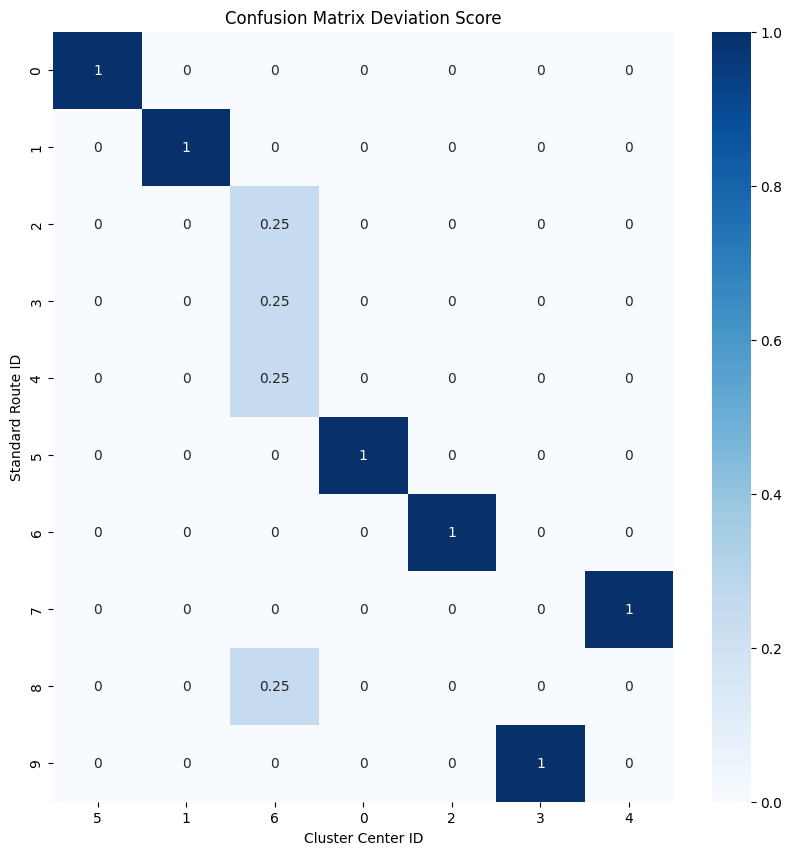

In [81]:
# Show confusion matrix
confusion_plot = plot_confusion_matrix(clustered_data) #  indices2from_to_prods)

In [18]:
best_settings['silhouette_score']['k']

7

Test all functions you want inside the run_all_tests() during development, for small sample sizes.


Code below is for actual result generation later, so that we can easily reuse intermediate values.

**Create a spark instance**

In [ ]:
spark_settings = {}
spark_instance = make_spark()

NameError: ignored

**Load and parse data**

In [ ]:
# Load and parse data
data_for_spark = parse_data()

**Perform clustering**

In [ ]:
# Run clustering and parameter tuning
clustering_settings = {
    'clustering_algorithm':'kmodes',
}
clustering_centroid_outcomes = run_clustering(
    spark_instance=spark_instance,
    data_for_spark, clustering_settings)

In [ ]:
# Evaluate clustering results
clustering_evaluation = evaluate_clustering(clustering_centroid_outcomes)

**Display results**

In [ ]:
# Display results (maybe only best result)
clustering_result = display_results(clustering_evaluation